In [555]:
import torch

## STEP 1.데이터 모으기

In [556]:
# # case 1

# N=20

# """
# 모델 출력과 차원 맞추기 위해 2차원으로
# 모델의 출력이 보통 (batch_size, 1) 형태
# 레이블도 같은 (batch_size, 1) 형태여야 손실 함수 계산 시 차원 오류 방지
# """
# random0=torch.randn(int(N/2),1)
# random5=torch.randn(int(N/2),1)+5

# class1_data=torch.hstack([random0,random5])
# class2_data=torch.hstack([random5, random0])

# class1_label=torch.ones(int(N/2),1)
# class2_label=torch.zeros(int(N/2),1)

# X=torch.vstack([class1_data,class2_data])
# y=torch.vstack([class1_label, class2_label])

# # print(class1_data)
# # print(class1_data[:2,0])

# case 2

N=100

radius1=0.3+0.05*torch.randn(int(N/2),1)
radius2=1+0.01*torch.randn(int(N/2),1)

theta1=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
theta2=2*torch.pi*torch.rand(int(N/2),1)-torch.pi

class1_data = torch.hstack([radius1*torch.cos(theta1), radius1*torch.sin(theta1)])
class2_data = torch.hstack([radius2*torch.cos(theta2), radius2*torch.sin(theta2)])

class1_label = torch.ones(int(N/2),1)
class2_label = torch.zeros(int(N/2),1)

X=torch.vstack([class1_data, class2_data])
y=torch.vstack([class1_label, class2_label])

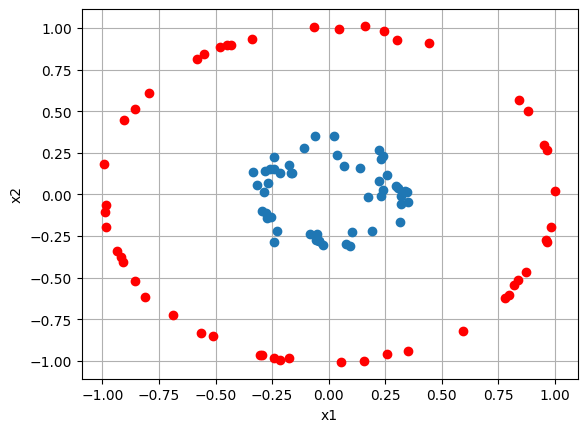

In [557]:
import matplotlib.pyplot as plt

plt.plot(class1_data[:,0], class1_data[:,1], 'o')
plt.plot(class2_data[:,0], class2_data[:,1], 'ro')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

## STEP 2.모델 만들기

In [558]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # # case 1, plain
        # self.linear = nn.Sequential(
        #     nn.Linear(2, 100), # 10, 100, 1000, 10000 으로 바꿔보면서 확인
        #     nn.Sigmoid(),
        #     nn.Linear(100, 1), # node가 많을수록 좋게 나옴
        #     nn.Sigmoid()
        # )

        # # case 1, very simple
        # self.linear = nn.Sequential(
        #     nn.Linear(2,1), # 아주 simple 한 것도 오히려 괜찮
        #     nn.Sigmoid()
        # )

        # # case 1, deep
        # self.linear = nn.Sequential( # deep 하면 오래 걸림 (Adam으로 바꿔서 해결)
        #     nn.Linear(2,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100, 100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,1),
        #     nn.Sigmoid()
        # )

        # # case 2, plain
        # self.linear = nn.Sequential(
        #     nn.Linear(2, 1000),
        #     nn.Sigmoid(),
        #     nn.Linear(1000, 1),
        #     nn.Sigmoid()
        # )

        # # case 2, very simple
        # self.linear = nn.Sequential(
        #     nn.Linear(2,1), # 선형 분류만 가능해서 불가
        #     nn.Sigmoid()
        # )

        # # case 2, deep
        # self.linear = nn.Sequential( # LR을 줄이니까 수렴
        #     nn.Linear(2,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100, 100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,1),
        #     nn.Sigmoid()
        # )

        # # case 2, very deep
        # """
        # gradient Vanishing 문제 발생
        # - 역전파(backpropagation) 과정에서 gradient가 점점 작아져서 거의 0에 가까워지는 현상이 발생
        # - 그 결과, 앞쪽 층의 가중치가 제대로 업데이트되지 않아 신경망이 제대로 학습되지 않는 문제가 생김
        # - 특히 sigmoid 함수는 미분 값이 최대 0.25로 작고, 여러 층을 통과하면서 gradient가 급격히 작아짐
        # - sigmoid 출력이 0 또는 1에 가까울수록 미분값이 0에 수렴 → gradient vanishing
        # """
        # self.linear = nn.Sequential(
        #     nn.Linear(2,100),
        #     nn.Sigmoid(),
        #     *[i for _ in range(10) for i in [nn.Linear(100,100), nn.Sigmoid()]],
        #     nn.Linear(100,1),
        #     nn.Sigmoid()
        # )

        # case 2, very deep relu
        self.linear = nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            *[i for _ in range(10) for i in [nn.Linear(100,100), nn.ReLU()]],
            nn.Linear(100,1),
            nn.Sigmoid() # BCELoss는 마지막에 Sigmoid()
            # MSELoss를 쓴다면 마지막에 ReLU 사용 가능(단, 여러가지 단점은 존재)
        )


    def forward(self, x):
        x = self.linear(x)
        return x

- case2 의 "선형 분류만 가능해서 불가" 에 대한 설명
- 모델은 직선 방정식 ax+by+c을 통해 출력값을 계산하고, 이 값이 sigmoid 함수에 들어가게 된다
- sigmoid의 출력값이 0.5가 되는 지점을 분류경계선 이라 한다
- ax+by+c=0 일때 sigmoid의 출력이 0.5가 나온다 즉, 직선의 방정식이 0인 것을 만족하는 x, y의 자취가 바로 분류경계선이 된다
- 따라서 이 모델은 오직 직선 형태의 경계선만 만들 수 있고,
case2 처럼 비선형 구조로 섞여 있는 데이터는 이런 방식으로는 분리할 수 없다.
- 학습이 진행되어도 Loss는 일정 수준 이하로 감소하지 않으며, 모델은 제대로 된 분류를 수행할 수 없다.

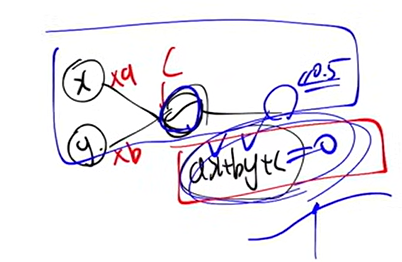

In [559]:
"""
unpacking operation 을 사용 : *[] 만나면 리스트가 사라짐

예)
nn.Sequential(*[
            nn.Linear(2,1), # 선형 분류만 가능해서 불가
            nn.Sigmoid()
        ])

이면


nn.Sequential(
            nn.Linear(2,1), # 선형 분류만 가능해서 불가
            nn.Sigmoid()
        )

형식이 된다
"""
# nn.Sequential(*[nn.Sequential(nn.Linear(100,100), nn.Sigmoid()) for _ in range(10)]) # Sequential안에 Sequential 반복되서 애매...
# nn.Sequential(*[nn.Linear(100,100) if i % 2 == 0 else nn.Sigmoid() for i in range(20)]) # 10개 만드는데 for문 20번 돌아서 애매...
# nn.Sequential(*[i for _ in range(10) for i in [nn.Linear(100,100), nn.Sigmoid()]])

# for _ in range(10):
#     for i in [nn.Linear(100,100), nn.Sigmoid()]:
#         print(i)

'\nunpacking operation 을 사용 : *[] 만나면 리스트가 사라짐\n\n예) \nnn.Sequential(*[\n            nn.Linear(2,1), # 선형 분류만 가능해서 불가\n            nn.Sigmoid()\n        ])\n\n이면 \n\n\nnn.Sequential(\n            nn.Linear(2,1), # 선형 분류만 가능해서 불가\n            nn.Sigmoid()\n        )\n\n형식이 된다\n'

In [560]:
model = MLP()
print(model)
print(model(torch.randn(5,2)).shape) # 2개 값으로 이루어진 좌표값 (x1, x2) 데이터 5개를 입력함

MLP(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): ReLU()
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): Linear(in_features=100, out_features=100, bias=True)
    (19): ReLU()
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ReLU()
    (22): Linear(in_features=100, out_features=1, bias=True)
    (23): Sigmoid()
  )
)
torch.Size([5, 1

In [561]:
from torch import optim
# from torchviz import make_dot

# LR = 1e-1 # case 1
# LR = 1e-2 # case 2, plain 에서 노드 천 개, deep
LR = 1e-4 # case 2, very deep relu

# EPOCH = 100 # case 1
EPOCH = 500 # case 1, deep / case 2, plain 에서 노드 천 개, deep, very deep relu

# optimizer = optim.SGD(model.parameters(), lr=LR)
optimizer = optim.Adam(model.parameters(), lr=LR) # case 1, deep
# optimizer = optim.Adam(model.parameters(), lr=LR, eps=0, betas=(0.9, 0.99))
# optimizer = optim.Adam(model.parameters(), lr=LR, eps=1e-12, betas=(0.1, 0.1))

criterion = nn.BCELoss()

loss_history = []
grad_history = []
update_size_history = []

model.train() # train mode로 전환
for ep in range(EPOCH):
    # inference
    y_hat = model(X)

    # loss
    loss = criterion(y_hat, y)

    # prev weights
    """
    Gradient Vanishing은 모델의 앞단(입력층에 가까운 층)에서 가장 심하게 발생하므로,
    이를 추적하기 위해 첫 번째 Linear 계층의 gradient와 업데이트량을 측정
    따라서 model.linear[0]을 기준으로 설정
    """
    prev=model.linear[0].weight.detach().clone()

    # update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # update amount
    grad_history += [torch.sum(torch.abs(model.linear[0].weight.grad)).item()]
    update_size_history += [torch.sum(torch.abs(model.linear[0].weight.detach() - prev)).item()]

    # print loss
    loss_history += [loss.item()]
    print(f"Epoch: {ep+1}, train loss: {loss.item():.4f}")
    print("-"*20)

Epoch: 1, train loss: 0.6939
--------------------
Epoch: 2, train loss: 0.6938
--------------------
Epoch: 3, train loss: 0.6938
--------------------
Epoch: 4, train loss: 0.6938
--------------------
Epoch: 5, train loss: 0.6938
--------------------
Epoch: 6, train loss: 0.6937
--------------------
Epoch: 7, train loss: 0.6937
--------------------
Epoch: 8, train loss: 0.6937
--------------------
Epoch: 9, train loss: 0.6937
--------------------
Epoch: 10, train loss: 0.6936
--------------------
Epoch: 11, train loss: 0.6936
--------------------
Epoch: 12, train loss: 0.6936
--------------------
Epoch: 13, train loss: 0.6936
--------------------
Epoch: 14, train loss: 0.6935
--------------------
Epoch: 15, train loss: 0.6935
--------------------
Epoch: 16, train loss: 0.6935
--------------------
Epoch: 17, train loss: 0.6935
--------------------
Epoch: 18, train loss: 0.6935
--------------------
Epoch: 19, train loss: 0.6934
--------------------
Epoch: 20, train loss: 0.6934
----------

In [562]:
# BinaryCrossEntropy
print(criterion(y_hat, y))
print(torch.sum(-torch.log(y_hat**y * (1-y_hat)**(1-y))) / N)

"""
만약에 예측이 0 이고 실제가 1이다. -> 할 수 있는 최악으로 못한것: 그때 Loss는 최대
100이 최대이다! -> 원래는 inf가 나와야 하는데 100이 나오는건 Pytorch에서 정해놓은 maximum 값임
https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html 내용
Our solution is that BCELoss clamps its log function outputs to be greater than or equal to -100.
"""
print(criterion(torch.tensor([0.]), torch.tensor([1.])))

tensor(2.7353e-05, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(2.7356e-05, grad_fn=<DivBackward0>)
tensor(100.)


Text(0, 0.5, 'Loss')

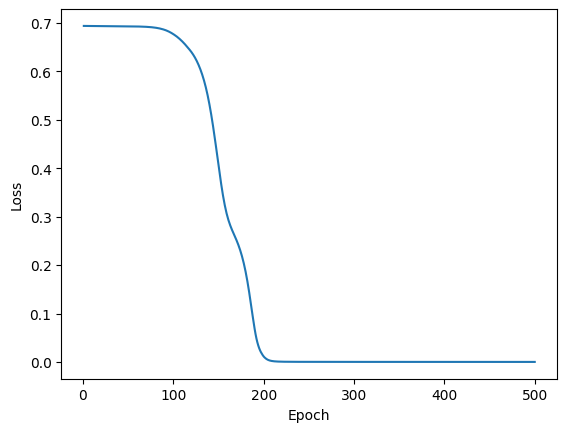

In [576]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(6,9))
# plt.subplot(2,1,1)
plt.plot(range(1, EPOCH+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plt.subplot(2,1,1)
# plt.plot(range(1, EPOCH+1), grad_history)
# plt.xlabel("Epoch")
# plt.ylabel("grad size")

## STEP 4.모델 테스트하기


Text(0.5, 0.5, 'x2')

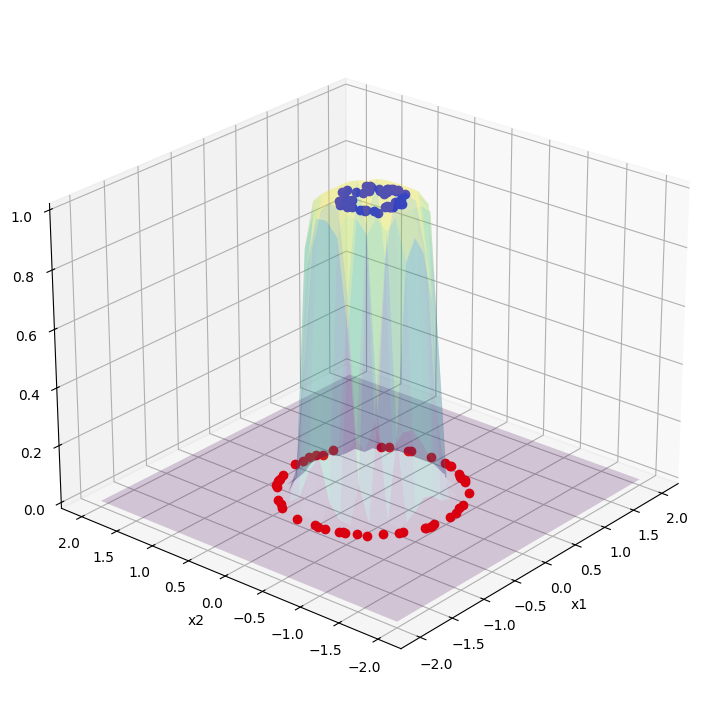

In [584]:
# x1_test=torch.linspace(-10,10,30) # case 1
# x2_test=torch.linspace(-10,10,30) # case 1
x1_test=torch.linspace(-2,2,30) # case 2
x2_test=torch.linspace(-2,2,30) # case 2

X1_test, X2_test = torch.meshgrid(x1_test, x2_test)
# print(X1_test.shape)
# print(X1_test.unsqueeze(dim=2).shape)

"""
개X채 또는 개X개X채 식으로 입력을 넣어줘야함
즉, 900개에 대해서 예측을 한다 라는 것
900X2 가 아닌 30X30X2로 통과 시키는 상황
"""
X_test=torch.cat([X1_test.unsqueeze(dim=2), X2_test.unsqueeze(dim=2)], dim=2)
# print(X_test.shape)

model.eval() # test model로 # 1. 해결
with torch.no_grad(): # 2. 해결
    y_hat = model(X_test)
# 1. dropout 혹은 BN 같은거 사용했다면 train mode와 test mode 동작이 다르므로 eval()로 mode를 바꿔줘야 함
# 2. grad_fn 계산 <- 메모리가 불필요하게 사용
Y_hat = y_hat.squeeze() # 모델을 통과하고 나면 30X30X1이 나올거고 squeeze()해서 30X30으로 만들어줌
# print(Y_hat.shape)


"""
현재 모델이 학습 상태인지 확인하고,
model.train()을 통해 학습 모드로 명시적으로 전환했는지 확인하는 테스트 코드
"""
# print(model.training)
# model.train()
# print(model.training)

plt.figure(figsize=[10,9])
ax = plt.axes(projection='3d')
ax.view_init(elev=25,azim=-140)

# from matplotlib.colors import LightSource
# ls = LightSource(azdeg=45, altdeg=30)
# rgb = ls.shade(Y_hat.numpy(), plt.cm.RdYlBu)
# ax.plot_surface(X1_test, X2_test, Y_hat.numpy(), facecolors=rgb, alpha=0.2)

# matplotlib은 ndarray만 다룰 수 있음
ax.plot_surface(X1_test, X2_test, Y_hat.numpy(), cmap='viridis', alpha=0.2)
plt.plot(class1_data[:,0], class1_data[:,1], class1_label.squeeze(), 'bo')
plt.plot(class2_data[:,0], class2_data[:,1], class2_label.squeeze(), 'ro')
plt.xlabel("x1")
plt.ylabel("x2")

In [565]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=X1_test, y=X2_test, z=Y_hat, colorscale="viridis", opacity=0.5)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title='binary classification', width=700, height=600)

- 파라미터 개수가 늘어나면 LR는 줄여주는게 국룰!
- 인공신경망은 함수이다 -> 파라미터가 크면 그만큼 함수가 변하는 정도가 훨씬 더 크다. 그러므로 파라미터 개수가 커지면 LR는 줄어야 한다.
- 모델을 만들때 100배 정도 커지면 LR은 10분의 1정도로 잡는게 적절하겠구나! 라고 감을 잡으면 된다.

- 또한 파라미터 개수가 늘어나면 Batch Size는 커짐
- Batch Size가 작을수록 왔다갔다 하는게 심할것 -> 조금 더 SGD에 가깝
- Batch Size를 키울수록 그래디언트를 구할때 좀 더 신중
- 즉, 파라미터가 높을수록 업데이트의 방향을 구할때 좀 더 신중해야 함
- gpt3 paper를 통해 알 수 있음

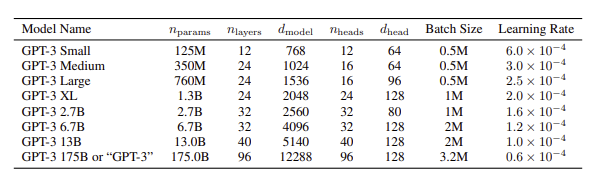

In [566]:
# tensorflow playground